# AdaBoost for Optical Character Recognition
We train a bunch of weak classifiers according to Adaptive Bootstrapping (Adaboost). The weak classifiers used here are decision trees with shallow depth but can be replaced with other weak classifiers as well. We classify between two handwritten numbers, 3 and 5. The data set used is from Oregon State University, Fall 2018 CS 534 Machine Learning Course Implementation Assignment 3.

There are 100 features for each sample, corresponding to the top 100 principal components generated using PCA from the original sample features of size 28 * 28.

The training set contains 4888 samples. Each sample is a list of 101 values. The first column represents the digit’s label which is 3 or 5. The other 100 floating values are the PCA-generated features for this sample.

The test set contains 1629 samples.

# Import Libraries

In [11]:
import copy
import time
import math
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Preprocessing Module

In [12]:
class Preprocessing:
    
    def __init__(self, raw_training_data_path, raw_validation_data_path):
            
            # Read the training and validation data. As the features are just PCA components, no need to observe the 
            # column names, so can proceed with numpy instead of pandas.
            
            self.raw_training_data = np.genfromtxt(raw_training_data_path, delimiter = ",")
            self.raw_validation_data = np.genfromtxt(raw_validation_data_path, delimiter = ",")
            
            print(self.raw_training_data[0:10,:])
            
            # split training features and labels
            self.training_features = self.raw_training_data[:, 1:]
            self.training_labels = self.raw_training_data[:, 0]
            
            print("No of training samples: {}, No of training features: {}".format(len(self.training_labels), self.training_features.shape[1]))
            
            
            # split validation features and labels
            self.validation_features = self.raw_validation_data[:, 1:]
            self.validation_labels = self.raw_validation_data[:, 0]
            
            print("No of validation samples: {}".format(len(self.validation_labels), ))

        
        

In [13]:
class Decision_Tree_Node:
    
    def __init__(self, X = None, y = None, depth = None):
        self.X = X
        self.y = y

        self.left = None
        self.right = None
        self.depth = depth
        self.feature_index_with_optimal_split = None
        self.threshold_for_optimal_split = None # since features are real values
        self.is_leaf = False
        self.class_probabilities = None


class Stump_Decision_Tree(BaseEstimator, ClassifierMixin):
    
    def __init__(self, root = None, max_depth = None, min_pool = None, weights_of_training_samples = None):
        '''
        Implementation of a stump decision tree i.e., a decision tree with a root and a pair of left and right children.

        Parameters
        -------------
        max_depth : int, optional, default 1
                    The maximum depth of the deicison tree. For a stump learner, by default 1.
        min_pool :  int, optional, default +INF
                    The minimum number of samples at a node after split. For a stump learner, no bound required.
        '''
        self.root = root
        self.max_depth = max_depth
        self.min_samples = min_pool
        self.classes = None
        self.weights_of_training_samples = weights_of_training_samples
    
    
    def build_decision_tree(self, X, y, node, current_depth):

        '''
        Recursively builds the decision tree if the terminal conditions not met
        
        Parameters
        -----------------
        X : training features
        y : training labels
        ''' 
        
        # base cases of recursion
        if current_depth >= self.max_depth:
            node.is_leaf = True
            
            
        elif len(y) <= self.min_samples:
            node.is_leaf = True
            
        
        elif len(np.unique(y)) == 1:
            node.is_leaf = True
        
        else:
            
            # find the best split and the feature that gives this best split
            feature_for_best_split, best_split_threshold, X_left, X_right, y_left, y_right = self.best_split(X, y)#, node.depth) 
            
            
            if feature_for_best_split is None:
                # best_split() returns None if no feature gave a split that has less impurity than the parent
                node.is_leaf = True
                
            else:
                
                # Recursively build trees to the left and the right using the best features and the best split threshold
                node.depth = current_depth
                node.feature_index_with_optimal_split = feature_for_best_split
                node.threshold_for_optimal_split = best_split_threshold
                
                node.left = Decision_Tree_Node(X_left, y_left, current_depth+1)
                node.right = Decision_Tree_Node(X_right, y_right, current_depth+1)
                
                # when a node is encountered, calculate the class probabilities for each class at this node and store
                node.left.class_probabilities = self.calculate_class_probabilities(y_left)
                node.right.class_probabilities = self.calculate_class_probabilities(y_right)
                
                self.build_decision_tree(X_left, y_left, node.left, current_depth+1)
                self.build_decision_tree(X_right, y_right, node.right, current_depth+1)
            
        
    
        
    def weighted_gini_impurity_before_split(self,y):
        '''
        Calculates the weighted GINI impurity of y before split.
        '''
        
        indices_of_label_3_samples = np.nonzero(y==3)[0]
        c_root_pos = 0
        
        for idx in indices_of_label_3_samples:
            c_root_pos += self.weights_of_training_samples[idx]
        
        
        c_root_total = np.sum(self.weights_of_training_samples)  
        
        
        c_root_neg = c_root_total - c_root_pos
        gini_of_y = 1 - (c_root_pos / c_root_total) ** 2 - ( c_root_neg/ c_root_total) ** 2
        return gini_of_y
  

    def weighted_gini_impurity_after_split(self, y_copy, indices_where_change, i):
        '''
        Calculates the weighted GINI impurity metric U after split of y_copy.
        
        U = (p^2) + (q^2 )
        
        where p = No of samples at this node with feature x below the node threshold/ No of samples at this node
              q = No of samples at this node with feature x equal or above the node threshold/ No of samples at this node
        
        Parameters
        -----------------
        '''

        indices_of_positive_elements_left = np.nonzero(y_copy[:indices_where_change[i] + 1]== 3)[0]
        CL_pos= 0
        
        for idx in indices_of_positive_elements_left:
            CL_pos += self.weights_of_training_samples[idx]
            
        CL_total = np.sum(self.weights_of_training_samples[:indices_where_change[i] + 1])
        CL_neg = CL_total - CL_pos
        prob1 = CL_pos / (CL_total)
        prob2 = CL_neg / (CL_total)
        UAL = 1 - (prob1) ** 2 - (prob2) ** 2
        
        
        
        indices_of_positive_elements_right = np.nonzero(y_copy[indices_where_change[i] + 1:]== 3)[0]
        CR_pos = 0
        for idx in indices_of_positive_elements_right:
            CR_pos += self.weights_of_training_samples[idx + indices_where_change[i] + 1]
            
        CR_total = np.sum(self.weights_of_training_samples[indices_where_change[i] + 1:])
        
        CR_neg = CR_total - CR_pos
        prob1 = CR_pos / (CR_total)
        prob2 = CR_neg / (CR_total)
        UAR = 1 - (prob1) ** 2 - (prob2) ** 2


        pl = (CL_total) / np.sum(self.weights_of_training_samples)
        pr = (CR_total) / np.sum(self.weights_of_training_samples)
        
        weighted_gini_after_split =  pl * UAL + pr * UAR
        return weighted_gini_after_split
    
    
    
    
    def split_node(self, X, y, best_feature, max_benefit_val):
        '''
        Split a node using the best feature that maximizes Information Gain.
        '''
        left_X, right_X, left_y, right_y = [],[],[],[]

        for row in range(0,X.shape[0]):
            if X[row][best_feature] < max_benefit_val:
                left_X.append(X[row])
                left_y.append(y[row])
            else:
                right_X.append(X[row])
                right_y.append(y[row])
        
        return np.array(left_X), np.array(right_X), np.array(left_y), np.array(right_y)
        
        
        
        
    def best_split(self, X_passed, y_passed):
        '''
        Divides the training samples into optimal splits according to the impurity metric
        '''
        numpy_X = []
        numpy_y = []
        
        for row in range(0,len(X_passed)):
            numpy_X.append(X_passed[row])
            numpy_y.append(y_passed[row])
        
        X = np.array(numpy_X)
        y = np.array(numpy_y)
        
        
        weighted_gini_before_split = self.weighted_gini_impurity_before_split(y)

        benefit_of_split = 0
        
        benefit_vals_for_one_feature = np.zeros(X.shape[1])
        max_benefit_index_for_each_feature = np.zeros(X.shape[1])
        
        
        # for each feature, find the GINI gain at each threshold
        for feature in range(0,X.shape[1]):
            current_feature = X[:, feature]
            
            # TRICK: Sort the training samples according to this feature's values
            # and find GINI only at samples where the class label changes.
            
            
            stacked = np.column_stack((y, current_feature)) # stack y_to_take and current_feature
            sortedd = stacked[np.argsort(stacked[:, 1])]
            
            y_copy = sortedd[..., 0]

            indices_where_change = np.where(y_copy[:-1] != y_copy[1:])[0]

            # the values in indices_where_change are the indices after which the label changes.
            for i in range(len(indices_where_change)):
                weighted_gini_after_split = self.weighted_gini_impurity_after_split(y_copy, indices_where_change, i)

                benefit_of_split = weighted_gini_before_split - weighted_gini_after_split


                if benefit_of_split >  benefit_vals_for_one_feature[feature]:
                    benefit_vals_for_one_feature[feature] = benefit_of_split  
                    max_benefit_index_for_each_feature[feature] = indices_where_change[i]
                                      

        if benefit_of_split == 0:
            #print("No good feature found.")
            return None, None, None, None, None, None
        else:
            
            best_feature = np.argmax(benefit_vals_for_one_feature)
            index_of_threhold_with_max_benefit_for_best_feature = max_benefit_index_for_each_feature[best_feature]
            
            # lets get the column of that feature and sort and get the threshold
            max_benefit_feature = copy.deepcopy(X[:,best_feature])
            max_benefit_feature.sort()
            
            # Athough we have threshold_index_for_best_split_in_indices_where_change, we need to find the
            # corresponding index in the sorted max benefit feature.
            

            max_benefit_val = max_benefit_feature[int(index_of_threhold_with_max_benefit_for_best_feature)+1]
            
            
            X_left, X_right, y_left, y_right = self.split_node(X, y, best_feature, max_benefit_val)
            
                        
            return best_feature, max_benefit_val, X_left, X_right, y_left, y_right
                
                        

                
    def calculate_class_probabilities(self, y):
        '''
        Calculates the probability of each class at this node
        '''
        
        class_probabilities = []
        
        for label in self.root.classes:
            
            if len(y[y==label]) == len(y) :
                class_prob = 1
            elif len(y[y==label]) == 0:
                class_prob = 0
            else:
                class_prob = y[y==label].shape[0]/len(y)
            
            class_probabilities.append(class_prob)
        
        return class_probabilities
        
            
            
    
    def predict_a_sample(self, x, node):
        '''
        Predicts a class label for the passed test sample by recursively calling a child node from the root upto
        a leaf node of the learned decision tree.
        
        Parameters
        ------------------
        x : a single test sample features
        node : a node of the learned decision tree
        '''
        
        if node.is_leaf:
            return node.class_probabilities
        else:
            
            if x[node.feature_index_with_optimal_split] < node.threshold_for_optimal_split:
                return self.predict_a_sample(x, node.left)
            else:
                return self.predict_a_sample(x, node.right)
    
    
    
    def predict(self, X):
        '''
        Predicts class labels for all test samples passed.
        
        Parameters
        ---------------------------
        X : test samples passed as 2D arrays
        '''
        
        
        
        test_preds = []
        for test_sample in X:
            class_probabilities = self.predict_a_sample(test_sample, self.root)
            test_pred = np.argmax(class_probabilities)
            if test_pred == 0:
                
                test_preds.append(3)
            elif test_pred == 1:
                test_preds.append(5)
            else:
                raise AssertionError
        
        return test_preds
        
       
    
    def fit(self, X, y):
        '''
        Train CART decision tree using GINI impurity.
        
        Parameters
        ----------------
        X : arraylike
            The training samples in 2D format, corresponding to input features of each sample.
        y : arraylike, optional, default None
            The labels for each sample in X. Some algorithms do not require the label y while some (like Decisoin Tree) do.
            Hence, keep y as optional.
        
        Returns
        ----------------
        self : Trained Decision Tree object
               This method returns self for compatibility reasons with sklearn's other interfaces/ functionalities.
        
        
        '''
        self.root = Decision_Tree_Node(X, y, 0)
        self.root.classes = list(set(y)) # gives the set of unique elements in y.
        self.root.classes.sort() # sorts in ascending order in-place if not already sorted
        
        #print("The unique classes present in training data:{}".format(self.root.classes))
        
        self.build_decision_tree(X = X, y = y, node = self.root, current_depth = 0)
    
    

Adaboost can be implemented using decision trees in two ways to ensure proper weightage of all the sample.<br>
1. Use weighted gini index using sample weights (As in this file) Or,
2. For each new weak learner, sample a new data set from the old one proportional to the updated sample weights.

In [17]:
class AdaBoost:
    
    def __init__(self, rounds_of_boosting):
        
        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.text_y = None
        
        self.sample_weights = []
        
        self.rounds_of_boosting = rounds_of_boosting
        self.random_forest = [] # adaboost maintains a forest of weak learners similar to random forest.
        self.weights_of_learners = []
    
    
    def calculate_learner_weight(self, sum_of_weighted_errors):
        '''
        Calculates alpha parameter that decides the weight of each learner in the final vote.
        '''
        assert 0 <= sum_of_weighted_errors and sum_of_weighted_errors <= 1
        weight_of_learner = 0.5 * ( math.log( (1-sum_of_weighted_errors + 0.00000000000001)/(sum_of_weighted_errors + 0.00000000000001) ) )
        
        if sum_of_weighted_errors < 0.5:
            if not weight_of_learner > 0:
                print("ValueError ",weight_of_learner)
                
        
        return weight_of_learner
    
    
    def update_sample_weights(self, learner_weight, old_sample_weights, individual_unweighted_errors):
        '''
        Updates the weights of individual samples based on the error made by the learner.
        '''
        unnormalized_updated_sample_weights = []
        
        for sample_weight_idx in range(0,len(old_sample_weights)):
            
            if individual_unweighted_errors[sample_weight_idx] == 0:
                e_power_multiplier = math.exp(-learner_weight)
            elif individual_unweighted_errors[sample_weight_idx] == 1:
                e_power_multiplier = math.exp(learner_weight)
            else:
                
                raise ValueError
            
            unnormalized_updated_sample_weights.append(old_sample_weights[sample_weight_idx] * e_power_multiplier)
        
        total_weight = sum(unnormalized_updated_sample_weights)
        normalized_updated_sample_weights = [item/total_weight for item in unnormalized_updated_sample_weights]
        
        return normalized_updated_sample_weights
                
            
            
        
    
    
    def calculate_weighted_error(self, X, y, weights_of_samples, learner):
        '''
        Calculates the weighted error made on each sample by the learner.
        '''        
        predictions = learner.predict(X)
        individual_unweighted_errors = []
        sum_of_weighted_errors = 0
        
        for sample in range(len(predictions)):
            
            if y[sample] != predictions[sample]:
                sum_of_weighted_errors += weights_of_samples[sample]
                individual_unweighted_errors.append(1)
            else:
                individual_unweighted_errors.append(0)
        
        
        assert 0 <= sum_of_weighted_errors and sum_of_weighted_errors <= 1
        assert sum(individual_unweighted_errors) < 0.5 * len(y)
        
        return sum_of_weighted_errors, individual_unweighted_errors
    
    
        
    
    
    def predict(self, X):
        '''
        Predicts the labels for different samples in X using majority vote of different weak learners.
        '''
        predictions_from_different_learners = []
        
        for idx in range(self.rounds_of_boosting):
            
            # make predictions for all the samples in X using this learner
            predictions = self.random_forest[idx].predict(X)
            predictions_from_different_learners.append(predictions)
            
        predictions_from_different_learners = np.array(predictions_from_different_learners)
        # Each row contains the predictions for different samples from one learner. 
        
        
        predictions_from_different_learners = predictions_from_different_learners.T
        # Each row contains the predictions for one sample from different learners. 
        
        # for all samples in X, vote using all the learners
        final_predictions = []
        
        for sample_idx in range(len(X)):
            
            cumulative_prediction_for_sample = 0
            for learner_no in range(self.rounds_of_boosting):
                
                
                
                if predictions_from_different_learners[sample_idx][learner_no] == 3:
                    cumulative_prediction_for_sample += (self.weights_of_learners[learner_no] )
                elif predictions_from_different_learners[sample_idx][learner_no] == 5:
                    cumulative_prediction_for_sample -= (self.weights_of_learners[learner_no] )
                else:
                    raise ValueError
            
            final_prediction = None
            if cumulative_prediction_for_sample >= 0:
                final_prediction = 3
                
            else:
                final_prediction = 5
                
            final_predictions.append(final_prediction)
        
        
        
        return final_predictions
                
                    
            
            
        
        
        
    
    def fit(self, X ,y):
        '''
        Trains an Adaboost instance.
        '''
        self.train_X = X
        self.train_y = y
        
        leng_of_training_set = len(X)
        
        current_sample_weights = [1/leng_of_training_set for _ in range(leng_of_training_set)]
        self.sample_weights.append(current_sample_weights)
        
        print("Original sample weights: ",current_sample_weights[0:5])
        
        
        for weak_learner_num in range(0,self.rounds_of_boosting):
            print("\nWeak Learner: {} is training.".format(weak_learner_num))
            
            # train a weak learner
            decision_tree_root = Decision_Tree_Node()
            weak_learner = Stump_Decision_Tree(root = decision_tree_root, max_depth = 9, min_pool = 1, weights_of_training_samples = current_sample_weights)
            weak_learner.fit(X, y)
            self.random_forest.append(weak_learner)
            
            # calculate weighted error
            sum_of_weighted_errors, individual_unweighted_errors = self.calculate_weighted_error(self.train_X, self.train_y, current_sample_weights, weak_learner)
            
            # update alpha for this learner
            weight_of_learner = self.calculate_learner_weight(sum_of_weighted_errors)
            
            self.weights_of_learners.append(weight_of_learner)
            
            # update the sample weights for all the training samples
            current_sample_weights = self.update_sample_weights(weight_of_learner, current_sample_weights, individual_unweighted_errors)
            print("Updated sample weights: ",current_sample_weights[0:5])
            
            
            # save the updated weights
            if weak_learner_num+1 < self.rounds_of_boosting:
                self.sample_weights.append(current_sample_weights)
            
            
            
        print("The voting weights of different learners of Adaboost forest: ",self.weights_of_learners,)    
            
            
        
        

In [18]:
# read data
training_data_path = "data/pa3_train_reduced.csv"
validation_data_path = "data/pa3_valid_reduced.csv"

preprocessing = Preprocessing(training_data_path, validation_data_path)


[[   5.     -252.5092 1040.6188 ...  -21.6094  -32.602    25.619 ]
 [   5.     -684.5502 -368.7191 ...  -36.3467   26.6937  -17.564 ]
 [   3.      119.2934  638.9885 ...   14.7913   48.7926  -94.5664]
 ...
 [   5.      972.0162   77.9232 ...  -35.5166  -16.6162  -43.1298]
 [   5.     -255.5209  144.6523 ...   75.572    34.6369   24.2973]
 [   3.      217.1434  592.4619 ...  -25.7318   55.1806    4.9309]]
No of training samples: 1000, No of training features: 100
No of validation samples: 1629


In [19]:
# Observe the trend for different no of trees in the adaboost forest.

no_of_boosting_rounds_list = [1,5,10,20]

training_accuracy = []
test_accuracy = []

for no_of_boosting_rounds in no_of_boosting_rounds_list:
    print("***************************************************")
    print("\nNo of boosting rounds for current Adaboost: {}".format(no_of_boosting_rounds))
    adaboost_instance = AdaBoost(rounds_of_boosting = no_of_boosting_rounds)
    adaboost_instance.fit(preprocessing.training_features, preprocessing.training_labels)
    
    
    # predict for both training data and test data
    training_predictions = adaboost_instance.predict(preprocessing.training_features)
    training_acc = accuracy_score(preprocessing.training_labels, training_predictions)
    training_accuracy.append(training_acc)
    
    
    test_predictions = adaboost_instance.predict(preprocessing.validation_features)
    test_acc = accuracy_score(preprocessing.validation_labels, test_predictions)
    test_accuracy.append(test_acc)
    print("Training Accuracy : {} Testing Accuracy : {}".format(training_acc, test_acc))
    
    




***************************************************

No of boosting rounds for current Adaboost: 1
Original sample weights:  [0.001, 0.001, 0.001, 0.001, 0.001]

Weak Learner: 0 is training.
Updated sample weights:  [0.003205128205128148, 0.0005924170616113955, 0.0005924170616113955, 0.0005924170616113955, 0.0005924170616113955]
The voting weights of different learners of Adaboost forest:  [0.8441482436731834]
Training Accuracy : 0.844 Testing Accuracy : 0.7691835481890731
***************************************************

No of boosting rounds for current Adaboost: 5
Original sample weights:  [0.001, 0.001, 0.001, 0.001, 0.001]

Weak Learner: 0 is training.
Updated sample weights:  [0.003205128205128148, 0.0005924170616113955, 0.0005924170616113955, 0.0005924170616113955, 0.0005924170616113955]

Weak Learner: 1 is training.
Updated sample weights:  [0.004467688659269917, 0.0004618882940925846, 0.0004618882940925846, 0.0004618882940925846, 0.0004618882940925846]

Weak Learner: 2 is t

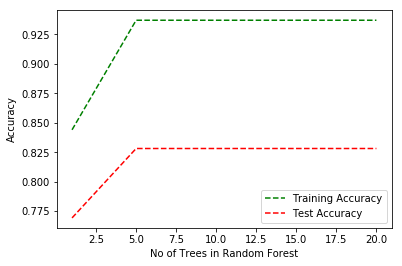

In [20]:
plt.plot(no_of_boosting_rounds_list, training_accuracy, 'g--', label="Training Accuracy")
plt.plot(no_of_boosting_rounds_list, test_accuracy, 'r--', label="Test Accuracy")
plt.xlabel("No of Trees in Random Forest")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
